In [41]:
# Load pretrained model, and generate new transformed dataset by passing images through pretrained model 
import os
import numpy as np
import pickle
import keras
from keras.datasets import cifar100
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
# Training parameters
batch_size = 125
epochs = 200
num_classes = 100

data_augmentation = True
subtract_pixel_mean = True

In [3]:
# Model parameter (CIFAR-10)
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

version = 2
n = 2
temperature = 3

In [4]:
depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype(float)
x_test = x_test.astype(float)

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [6]:
label_embeddings = pickle.load(open("Data/Embeddings/CIFAR/CIFAR_100_label_to_embedding_google_news.pk", "rb"))
embedding_len = len(label_embeddings[0])

y_train_embeddings = np.zeros((50000, embedding_len))
y_test_embeddings = np.zeros((10000, embedding_len))

for i in range(y_train.shape[0]):
    y_train_embeddings[i] = label_embeddings[int(y_train[i][0])]

for i in range(y_test.shape[0]):
    y_test_embeddings[i] = label_embeddings[int(y_test[i][0])]

label_embeddings_arr = np.zeros((100, embedding_len))
for i in range(100):
    label_embeddings_arr[i] = label_embeddings[i]

In [7]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
input_shape = x_train[0].shape

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 100)
y_test shape: (10000, 100)


In [8]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    
    return x

In [9]:
def resnet_v2(input_shape, depth, num_classes=100, temperature=1):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=4)(x)
    
    x = Flatten()(x)
    
    x = Dense(1024) (x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    outputs_hard = Dense(num_classes, kernel_initializer='he_normal')(x)
    outputs_hard = Lambda(lambda x: x/temperature)(outputs_hard)
    outputs_hard = Activation('softmax', name='hard')(outputs_hard)
    
    outputs_soft = Dense(embedding_len) (x)
    outputs_soft = Activation('relu')(outputs_soft)
    outputs_soft = BatchNormalization()(outputs_soft)
    
    outputs_soft = Dense(embedding_len, name='soft')(x)
    
    # Instantiate model.
    model = Model(inputs=inputs, outputs=[outputs_hard, outputs_soft])

    return model

In [10]:
if data_augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0
    )
else:
    datagen = ImageDataGenerator()

In [11]:
def multi_output_generator(generator, inputs, outputs1, outputs2, batch_size=128, seed=0):
    generator1 = datagen.flow(x=inputs, y=outputs1, batch_size=batch_size, seed=seed)
    generator2 = datagen.flow(x=inputs, y=outputs2, batch_size=batch_size, seed=seed)
    while True:
        X1 = generator1.next()
        X2 = generator2.next()
        
        yield X1[0], {"hard": X1[1], "soft": X2[1]}

In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    elif epoch > 40:
        lr *= 5e-1
    print('Learning rate: ', lr)
    
    return lr

In [13]:
losses = {"hard": "categorical_crossentropy",
          "soft": "cosine_proximity"
         }
loss_weights = {"hard": 1.0, "soft": 2.0}
metrics={"hard": "acc"}

In [15]:
for temperature in [50, 20, 10, 5, 3, 1, 0.5, 0.1]:
    print('\n\nTemperature: %s' % (temperature))
    save_dir = os.path.join(os.getcwd(), 'saved_models/%s/combined/temp%s/' % (model_type, temperature))
    model_name = 'cifar100_%s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    
    
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_soft_loss',
                                 verbose=1,
                                 save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)

    callbacks = [checkpoint, lr_reducer, lr_scheduler]
    
    
    model = resnet_v2(input_shape=input_shape, depth=depth, temperature=temperature)
    model.compile(optimizer=Adam(lr=lr_schedule(0)),
                  loss=losses, 
                  loss_weights = loss_weights, 
                  metrics=metrics)

    
    history = model.fit_generator(epochs=epochs, 
                              generator=multi_output_generator(datagen, x_train, 
                                                               y_train, y_train_embeddings, batch_size=batch_size),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=multi_output_generator(datagen, x_test, 
                                                                     y_test, y_test_embeddings, batch_size=batch_size),
                              validation_steps = x_test.shape[0] // batch_size,
                              verbose=1, callbacks=callbacks)
    
    
    history_filepath = os.path.join(save_dir, 'cifar100_%s_w2v_history_temp.pk' % (model_type))
    pickle.dump(history, open(history_filepath, "wb"))



Temperature: 50
Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
400/400 [==============================] - 34s 86ms/step - loss: 3.6284 - hard_loss: 4.2386 - soft_loss: -0.4527 - hard_acc: 0.0757 - val_loss: 3.2577 - val_hard_loss: 4.0070 - val_soft_loss: -0.4823 - val_hard_acc: 0.1133

Epoch 00001: val_soft_loss improved from inf to -0.48232, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp50/cifar100_ResNet20v2_model.001.h5
Epoch 2/200
Learning rate:  0.001
400/400 [==============================] - 30s 74ms/step - loss: 2.7218 - hard_loss: 3.5522 - soft_loss: -0.5146 - hard_acc: 0.1784 - val_loss: 2.4995 - val_hard_loss: 3.3370 - val_soft_loss: -0.5145 - val_hard_acc: 0.2118

Epoch 00002: val_soft_loss improved from -0.48232 to -0.51452, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp50/cifar100_ResNet20v2_model.002.h5
Epoch 3/200
Learning rate:  0.001
400/400 [======================


Epoch 00041: val_soft_loss did not improve from -0.73963
Epoch 42/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -0.7678 - hard_loss: 0.5394 - soft_loss: -0.8160 - hard_acc: 0.8398 - val_loss: 0.1415 - val_hard_loss: 1.3395 - val_soft_loss: -0.7600 - val_hard_acc: 0.6484

Epoch 00042: val_soft_loss improved from -0.73963 to -0.76002, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp50/cifar100_ResNet20v2_model.042.h5
Epoch 43/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -0.8269 - hard_loss: 0.4970 - soft_loss: -0.8217 - hard_acc: 0.8537 - val_loss: 0.1197 - val_hard_loss: 1.3230 - val_soft_loss: -0.7603 - val_hard_acc: 0.6455

Epoch 00043: val_soft_loss improved from -0.76002 to -0.76026, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp50/cifar100_ResNet20v2_model.043.h5
Epoch 44/200
Learning rate:  0.0005



Epoch 00064: val_soft_loss did not improve from -0.76515
Epoch 65/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.1310 - hard_loss: 0.3003 - soft_loss: -0.8525 - hard_acc: 0.9105 - val_loss: 0.2087 - val_hard_loss: 1.4464 - val_soft_loss: -0.7555 - val_hard_acc: 0.6396

Epoch 00065: val_soft_loss did not improve from -0.76515
Epoch 66/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.1337 - hard_loss: 0.2982 - soft_loss: -0.8524 - hard_acc: 0.9121 - val_loss: 0.2351 - val_hard_loss: 1.4895 - val_soft_loss: -0.7634 - val_hard_acc: 0.6441

Epoch 00066: val_soft_loss did not improve from -0.76515
Epoch 67/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.1423 - hard_loss: 0.2925 - soft_loss: -0.8534 - hard_acc: 0.9122 - val_loss: 0.2320 - val_hard_loss: 1.4737 - val_soft_loss: -0.7567 - val_hard_acc: 0.6421

Epoch 00067: val_soft_loss did not improve fr

400/400 [==============================] - 30s 74ms/step - loss: -1.5008 - hard_loss: 0.0826 - soft_loss: -0.9061 - hard_acc: 0.9818 - val_loss: 0.1386 - val_hard_loss: 1.4678 - val_soft_loss: -0.7787 - val_hard_acc: 0.6718

Epoch 00113: val_soft_loss did not improve from -0.78248
Epoch 114/200
Learning rate:  0.0001
400/400 [==============================] - 30s 74ms/step - loss: -1.4990 - hard_loss: 0.0843 - soft_loss: -0.9055 - hard_acc: 0.9807 - val_loss: 0.1088 - val_hard_loss: 1.4370 - val_soft_loss: -0.7777 - val_hard_acc: 0.6770

Epoch 00114: val_soft_loss did not improve from -0.78248
Epoch 115/200
Learning rate:  0.0001
400/400 [==============================] - 30s 74ms/step - loss: -1.5022 - hard_loss: 0.0833 - soft_loss: -0.9062 - hard_acc: 0.9810 - val_loss: 0.0883 - val_hard_loss: 1.4186 - val_soft_loss: -0.7783 - val_hard_acc: 0.6738

Epoch 00115: val_soft_loss did not improve from -0.78248
Epoch 116/200
Learning rate:  0.0001
400/400 [==============================] - 

400/400 [==============================] - 30s 75ms/step - loss: -1.5518 - hard_loss: 0.0599 - soft_loss: -0.9154 - hard_acc: 0.9886 - val_loss: 0.0950 - val_hard_loss: 1.4338 - val_soft_loss: -0.7789 - val_hard_acc: 0.6769

Epoch 00139: val_soft_loss did not improve from -0.78248
Epoch 140/200
Learning rate:  1e-05
400/400 [==============================] - 30s 74ms/step - loss: -1.5496 - hard_loss: 0.0625 - soft_loss: -0.9155 - hard_acc: 0.9878 - val_loss: 0.1057 - val_hard_loss: 1.4440 - val_soft_loss: -0.7786 - val_hard_acc: 0.6749

Epoch 00140: val_soft_loss did not improve from -0.78248
Epoch 141/200
Learning rate:  1e-05
400/400 [==============================] - 30s 74ms/step - loss: -1.5508 - hard_loss: 0.0609 - soft_loss: -0.9152 - hard_acc: 0.9885 - val_loss: 0.0828 - val_hard_loss: 1.4261 - val_soft_loss: -0.7810 - val_hard_acc: 0.6770

Epoch 00141: val_soft_loss did not improve from -0.78248
Epoch 142/200
Learning rate:  1e-05
400/400 [==============================] - 30s

400/400 [==============================] - 30s 74ms/step - loss: -1.5626 - hard_loss: 0.0565 - soft_loss: -0.9177 - hard_acc: 0.9896 - val_loss: 0.1098 - val_hard_loss: 1.4493 - val_soft_loss: -0.7780 - val_hard_acc: 0.6756

Epoch 00165: val_soft_loss did not improve from -0.78248
Epoch 166/200
Learning rate:  1e-06
400/400 [==============================] - 30s 74ms/step - loss: -1.5620 - hard_loss: 0.0567 - soft_loss: -0.9175 - hard_acc: 0.9896 - val_loss: 0.0896 - val_hard_loss: 1.4324 - val_soft_loss: -0.7796 - val_hard_acc: 0.6783

Epoch 00166: val_soft_loss did not improve from -0.78248
Epoch 167/200
Learning rate:  1e-06
400/400 [==============================] - 30s 74ms/step - loss: -1.5647 - hard_loss: 0.0559 - soft_loss: -0.9184 - hard_acc: 0.9893 - val_loss: 0.0762 - val_hard_loss: 1.4192 - val_soft_loss: -0.7797 - val_hard_acc: 0.6812

Epoch 00167: val_soft_loss did not improve from -0.78248
Epoch 168/200
Learning rate:  1e-06
400/400 [==============================] - 30s

400/400 [==============================] - 30s 74ms/step - loss: -1.5645 - hard_loss: 0.0563 - soft_loss: -0.9184 - hard_acc: 0.9901 - val_loss: 0.0982 - val_hard_loss: 1.4421 - val_soft_loss: -0.7800 - val_hard_acc: 0.6751

Epoch 00191: val_soft_loss did not improve from -0.78248
Epoch 192/200
Learning rate:  5e-07
400/400 [==============================] - 30s 74ms/step - loss: -1.5647 - hard_loss: 0.0566 - soft_loss: -0.9187 - hard_acc: 0.9898 - val_loss: 0.0983 - val_hard_loss: 1.4402 - val_soft_loss: -0.7790 - val_hard_acc: 0.6756

Epoch 00192: val_soft_loss did not improve from -0.78248
Epoch 193/200
Learning rate:  5e-07
400/400 [==============================] - 30s 74ms/step - loss: -1.5651 - hard_loss: 0.0562 - soft_loss: -0.9187 - hard_acc: 0.9890 - val_loss: 0.1070 - val_hard_loss: 1.4481 - val_soft_loss: -0.7786 - val_hard_acc: 0.6755

Epoch 00193: val_soft_loss did not improve from -0.78248
Epoch 194/200
Learning rate:  5e-07
400/400 [==============================] - 30s


Epoch 00012: val_soft_loss improved from -0.64811 to -0.66174, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp20/cifar100_ResNet20v2_model.012.h5
Epoch 13/200
Learning rate:  0.001
400/400 [==============================] - 30s 75ms/step - loss: 0.2783 - hard_loss: 1.3931 - soft_loss: -0.6871 - hard_acc: 0.6079 - val_loss: 0.7087 - val_hard_loss: 1.7626 - val_soft_loss: -0.6575 - val_hard_acc: 0.5185

Epoch 00013: val_soft_loss did not improve from -0.66174
Epoch 14/200
Learning rate:  0.001
400/400 [==============================] - 30s 75ms/step - loss: 0.2219 - hard_loss: 1.3474 - soft_loss: -0.6940 - hard_acc: 0.6175 - val_loss: 0.6128 - val_hard_loss: 1.6746 - val_soft_loss: -0.6630 - val_hard_acc: 0.5422

Epoch 00014: val_soft_loss improved from -0.66174 to -0.66300, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp20/cifar100_ResNet20v2_model.014.h5
Epoch 15/200
Learning rate:  0.001
400/4


Epoch 00033: val_soft_loss did not improve from -0.72109
Epoch 34/200
Learning rate:  0.001
400/400 [==============================] - 30s 75ms/step - loss: -0.5178 - hard_loss: 0.7144 - soft_loss: -0.7713 - hard_acc: 0.7847 - val_loss: 0.3632 - val_hard_loss: 1.5010 - val_soft_loss: -0.7245 - val_hard_acc: 0.6051

Epoch 00034: val_soft_loss improved from -0.72109 to -0.72451, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp20/cifar100_ResNet20v2_model.034.h5
Epoch 35/200
Learning rate:  0.001
400/400 [==============================] - 30s 75ms/step - loss: -0.5502 - hard_loss: 0.6872 - soft_loss: -0.7745 - hard_acc: 0.7908 - val_loss: 0.4182 - val_hard_loss: 1.5423 - val_soft_loss: -0.7183 - val_hard_acc: 0.5988

Epoch 00035: val_soft_loss did not improve from -0.72451
Epoch 36/200
Learning rate:  0.001
400/400 [==============================] - 30s 75ms/step - loss: -0.5572 - hard_loss: 0.6806 - soft_loss: -0.7756 - hard_acc: 0.7949 - val


Epoch 00079: val_soft_loss did not improve from -0.76044
Epoch 80/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.2633 - hard_loss: 0.1951 - soft_loss: -0.8545 - hard_acc: 0.9400 - val_loss: 0.3984 - val_hard_loss: 1.6651 - val_soft_loss: -0.7584 - val_hard_acc: 0.6373

Epoch 00080: val_soft_loss did not improve from -0.76044
Epoch 81/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.2759 - hard_loss: 0.1857 - soft_loss: -0.8557 - hard_acc: 0.9443 - val_loss: 0.4074 - val_hard_loss: 1.6698 - val_soft_loss: -0.7559 - val_hard_acc: 0.6348

Epoch 00081: val_soft_loss did not improve from -0.76044
Epoch 82/200
Learning rate:  0.0001
400/400 [==============================] - 30s 75ms/step - loss: -1.3549 - hard_loss: 0.1353 - soft_loss: -0.8696 - hard_acc: 0.9616 - val_loss: 0.2157 - val_hard_loss: 1.5144 - val_soft_loss: -0.7735 - val_hard_acc: 0.6614

Epoch 00082: val_soft_loss improved from -0.7

400/400 [==============================] - 30s 75ms/step - loss: -1.4979 - hard_loss: 0.0671 - soft_loss: -0.8938 - hard_acc: 0.9851 - val_loss: 0.2101 - val_hard_loss: 1.5346 - val_soft_loss: -0.7732 - val_hard_acc: 0.6643

Epoch 00104: val_soft_loss did not improve from -0.77626
Epoch 105/200
Learning rate:  0.0001
400/400 [==============================] - 30s 75ms/step - loss: -1.4988 - hard_loss: 0.0678 - soft_loss: -0.8940 - hard_acc: 0.9845 - val_loss: 0.2124 - val_hard_loss: 1.5352 - val_soft_loss: -0.7718 - val_hard_acc: 0.6667

Epoch 00105: val_soft_loss did not improve from -0.77626
Epoch 106/200
Learning rate:  0.0001
400/400 [==============================] - 30s 75ms/step - loss: -1.5044 - hard_loss: 0.0659 - soft_loss: -0.8953 - hard_acc: 0.9856 - val_loss: 0.2261 - val_hard_loss: 1.5516 - val_soft_loss: -0.7727 - val_hard_acc: 0.6637

Epoch 00106: val_soft_loss did not improve from -0.77626
Epoch 107/200
Learning rate:  0.0001
400/400 [==============================] - 

400/400 [==============================] - 30s 75ms/step - loss: -1.5662 - hard_loss: 0.0437 - soft_loss: -0.9071 - hard_acc: 0.9916 - val_loss: 0.2113 - val_hard_loss: 1.5575 - val_soft_loss: -0.7752 - val_hard_acc: 0.6712

Epoch 00130: val_soft_loss did not improve from -0.77626
Epoch 131/200
Learning rate:  1e-05
400/400 [==============================] - 30s 75ms/step - loss: -1.5641 - hard_loss: 0.0447 - soft_loss: -0.9065 - hard_acc: 0.9914 - val_loss: 0.2248 - val_hard_loss: 1.5660 - val_soft_loss: -0.7727 - val_hard_acc: 0.6671

Epoch 00131: val_soft_loss did not improve from -0.77626
Epoch 132/200
Learning rate:  1e-05
400/400 [==============================] - 30s 75ms/step - loss: -1.5680 - hard_loss: 0.0435 - soft_loss: -0.9078 - hard_acc: 0.9918 - val_loss: 0.1904 - val_hard_loss: 1.5379 - val_soft_loss: -0.7757 - val_hard_acc: 0.6690

Epoch 00132: val_soft_loss did not improve from -0.77626
Epoch 133/200
Learning rate:  1e-05
400/400 [==============================] - 30s

400/400 [==============================] - 30s 75ms/step - loss: -1.5774 - hard_loss: 0.0402 - soft_loss: -0.9094 - hard_acc: 0.9928 - val_loss: 0.2278 - val_hard_loss: 1.5735 - val_soft_loss: -0.7735 - val_hard_acc: 0.6697

Epoch 00155: val_soft_loss did not improve from -0.77769
Epoch 156/200
Learning rate:  1e-05
400/400 [==============================] - 30s 75ms/step - loss: -1.5757 - hard_loss: 0.0417 - soft_loss: -0.9093 - hard_acc: 0.9925 - val_loss: 0.2288 - val_hard_loss: 1.5789 - val_soft_loss: -0.7756 - val_hard_acc: 0.6682

Epoch 00156: val_soft_loss did not improve from -0.77769
Epoch 157/200
Learning rate:  1e-05
400/400 [==============================] - 30s 75ms/step - loss: -1.5781 - hard_loss: 0.0407 - soft_loss: -0.9100 - hard_acc: 0.9922 - val_loss: 0.2277 - val_hard_loss: 1.5728 - val_soft_loss: -0.7731 - val_hard_acc: 0.6677

Epoch 00157: val_soft_loss did not improve from -0.77769
Epoch 158/200
Learning rate:  1e-05
400/400 [==============================] - 30s

400/400 [==============================] - 30s 75ms/step - loss: -1.5820 - hard_loss: 0.0385 - soft_loss: -0.9104 - hard_acc: 0.9928 - val_loss: 0.1938 - val_hard_loss: 1.5422 - val_soft_loss: -0.7744 - val_hard_acc: 0.6703

Epoch 00181: val_soft_loss did not improve from -0.77769
Epoch 182/200
Learning rate:  5e-07
400/400 [==============================] - 30s 75ms/step - loss: -1.5835 - hard_loss: 0.0384 - soft_loss: -0.9111 - hard_acc: 0.9932 - val_loss: 0.2319 - val_hard_loss: 1.5812 - val_soft_loss: -0.7748 - val_hard_acc: 0.6688

Epoch 00182: val_soft_loss did not improve from -0.77769
Epoch 183/200
Learning rate:  5e-07
400/400 [==============================] - 30s 75ms/step - loss: -1.5830 - hard_loss: 0.0381 - soft_loss: -0.9107 - hard_acc: 0.9931 - val_loss: 0.1954 - val_hard_loss: 1.5410 - val_soft_loss: -0.7730 - val_hard_acc: 0.6687

Epoch 00183: val_soft_loss did not improve from -0.77769
Epoch 184/200
Learning rate:  5e-07
400/400 [==============================] - 30s

400/400 [==============================] - 30s 76ms/step - loss: 1.0322 - hard_loss: 1.9819 - soft_loss: -0.6101 - hard_acc: 0.4674 - val_loss: 1.1828 - val_hard_loss: 2.1074 - val_soft_loss: -0.5976 - val_hard_acc: 0.4393

Epoch 00005: val_soft_loss improved from -0.58168 to -0.59764, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp10/cifar100_ResNet20v2_model.005.h5
Epoch 6/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 0.8744 - hard_loss: 1.8513 - soft_loss: -0.6239 - hard_acc: 0.4945 - val_loss: 1.1366 - val_hard_loss: 2.0741 - val_soft_loss: -0.6045 - val_hard_acc: 0.4499

Epoch 00006: val_soft_loss improved from -0.59764 to -0.60445, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp10/cifar100_ResNet20v2_model.006.h5
Epoch 7/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 0.7411 - hard_loss: 1.7435 - soft_l


Epoch 00024: val_soft_loss improved from -0.69721 to -0.70034, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp10/cifar100_ResNet20v2_model.024.h5
Epoch 25/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: -0.3376 - hard_loss: 0.8485 - soft_loss: -0.7451 - hard_acc: 0.7466 - val_loss: 0.5050 - val_hard_loss: 1.5835 - val_soft_loss: -0.6918 - val_hard_acc: 0.5814

Epoch 00025: val_soft_loss did not improve from -0.70034
Epoch 26/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: -0.3639 - hard_loss: 0.8260 - soft_loss: -0.7479 - hard_acc: 0.7524 - val_loss: 0.5988 - val_hard_loss: 1.6682 - val_soft_loss: -0.6882 - val_hard_acc: 0.5690

Epoch 00026: val_soft_loss did not improve from -0.70034
Epoch 27/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: -0.3921 - hard_loss: 0.8048 - soft_loss: -0.7522 - hard_acc: 0.7605 - val

Epoch 46/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.0048 - hard_loss: 0.3256 - soft_loss: -0.8171 - hard_acc: 0.9017 - val_loss: 0.2684 - val_hard_loss: 1.4656 - val_soft_loss: -0.7496 - val_hard_acc: 0.6411

Epoch 00046: val_soft_loss did not improve from -0.75378
Epoch 47/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.0167 - hard_loss: 0.3184 - soft_loss: -0.8176 - hard_acc: 0.9026 - val_loss: 0.2607 - val_hard_loss: 1.4646 - val_soft_loss: -0.7511 - val_hard_acc: 0.6373

Epoch 00047: val_soft_loss did not improve from -0.75378
Epoch 48/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.0331 - hard_loss: 0.3089 - soft_loss: -0.8193 - hard_acc: 0.9066 - val_loss: 0.2598 - val_hard_loss: 1.4677 - val_soft_loss: -0.7515 - val_hard_acc: 0.6485

Epoch 00048: val_soft_loss did not improve from -0.75378
Epoch 49/200
Learning rate:  0.0005
400/400 [=

400/400 [==============================] - 30s 76ms/step - loss: -1.2387 - hard_loss: 0.1915 - soft_loss: -0.8428 - hard_acc: 0.9411 - val_loss: 0.4758 - val_hard_loss: 1.7275 - val_soft_loss: -0.7533 - val_hard_acc: 0.6355

Epoch 00071: val_soft_loss did not improve from -0.75862
Epoch 72/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.2475 - hard_loss: 0.1867 - soft_loss: -0.8442 - hard_acc: 0.9428 - val_loss: 0.4175 - val_hard_loss: 1.6799 - val_soft_loss: -0.7582 - val_hard_acc: 0.6400

Epoch 00072: val_soft_loss did not improve from -0.75862
Epoch 73/200
Learning rate:  0.0005
400/400 [==============================] - 30s 75ms/step - loss: -1.2503 - hard_loss: 0.1852 - soft_loss: -0.8445 - hard_acc: 0.9429 - val_loss: 0.4040 - val_hard_loss: 1.6654 - val_soft_loss: -0.7573 - val_hard_acc: 0.6414

Epoch 00073: val_soft_loss did not improve from -0.75862
Epoch 74/200
Learning rate:  0.0005
400/400 [==============================] - 30s


Epoch 00094: val_soft_loss did not improve from -0.77521
Epoch 95/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4748 - hard_loss: 0.0624 - soft_loss: -0.8838 - hard_acc: 0.9851 - val_loss: 1.0716 - val_hard_loss: 1.5889 - val_soft_loss: -0.3735 - val_hard_acc: 0.6676

Epoch 00095: val_soft_loss did not improve from -0.77521
Epoch 96/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4803 - hard_loss: 0.0591 - soft_loss: -0.8842 - hard_acc: 0.9859 - val_loss: 0.2301 - val_hard_loss: 1.5526 - val_soft_loss: -0.7754 - val_hard_acc: 0.6698

Epoch 00096: val_soft_loss improved from -0.77521 to -0.77541, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp10/cifar100_ResNet20v2_model.096.h5
Epoch 97/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4825 - hard_loss: 0.0585 - soft_loss: -0.8844 - hard_acc: 0.9867 - 


Epoch 00119: val_soft_loss did not improve from -0.77560
Epoch 120/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.5449 - hard_loss: 0.0455 - soft_loss: -0.8966 - hard_acc: 0.9894 - val_loss: 0.2761 - val_hard_loss: 1.6212 - val_soft_loss: -0.7737 - val_hard_acc: 0.6699

Epoch 00120: val_soft_loss did not improve from -0.77560
Epoch 121/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.5468 - hard_loss: 0.0450 - soft_loss: -0.8968 - hard_acc: 0.9896 - val_loss: 0.3164 - val_hard_loss: 1.6562 - val_soft_loss: -0.7706 - val_hard_acc: 0.6691

Epoch 00121: val_soft_loss did not improve from -0.77560
Epoch 122/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5555 - hard_loss: 0.0419 - soft_loss: -0.8994 - hard_acc: 0.9903 - val_loss: 0.2773 - val_hard_loss: 1.6240 - val_soft_loss: -0.7740 - val_hard_acc: 0.6679

Epoch 00122: val_soft_loss did not improve 

400/400 [==============================] - 30s 75ms/step - loss: -1.5800 - hard_loss: 0.0312 - soft_loss: -0.9050 - hard_acc: 0.9939 - val_loss: 0.2491 - val_hard_loss: 1.6044 - val_soft_loss: -0.7770 - val_hard_acc: 0.6751

Epoch 00144: val_soft_loss did not improve from -0.77864
Epoch 145/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5772 - hard_loss: 0.0334 - soft_loss: -0.9046 - hard_acc: 0.9931 - val_loss: 1.4146 - val_hard_loss: 1.6360 - val_soft_loss: -0.2099 - val_hard_acc: 0.6737

Epoch 00145: val_soft_loss did not improve from -0.77864
Epoch 146/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5784 - hard_loss: 0.0327 - soft_loss: -0.9048 - hard_acc: 0.9932 - val_loss: 0.2353 - val_hard_loss: 1.5922 - val_soft_loss: -0.7776 - val_hard_acc: 0.6782

Epoch 00146: val_soft_loss did not improve from -0.77864
Epoch 147/200
Learning rate:  1e-05
400/400 [==============================] - 30s

400/400 [==============================] - 30s 75ms/step - loss: -1.5867 - hard_loss: 0.0297 - soft_loss: -0.9063 - hard_acc: 0.9945 - val_loss: 0.2762 - val_hard_loss: 1.6327 - val_soft_loss: -0.7764 - val_hard_acc: 0.6709

Epoch 00195: val_soft_loss did not improve from -0.77911
Epoch 196/200
Learning rate:  5e-07
400/400 [==============================] - 30s 75ms/step - loss: -1.5865 - hard_loss: 0.0300 - soft_loss: -0.9064 - hard_acc: 0.9941 - val_loss: 0.2648 - val_hard_loss: 1.6198 - val_soft_loss: -0.7756 - val_hard_acc: 0.6712

Epoch 00196: val_soft_loss did not improve from -0.77911
Epoch 197/200
Learning rate:  5e-07
400/400 [==============================] - 30s 75ms/step - loss: -1.5894 - hard_loss: 0.0287 - soft_loss: -0.9071 - hard_acc: 0.9947 - val_loss: 0.2911 - val_hard_loss: 1.6443 - val_soft_loss: -0.7747 - val_hard_acc: 0.6757

Epoch 00197: val_soft_loss did not improve from -0.77911
Epoch 198/200
Learning rate:  5e-07
400/400 [==============================] - 30s


Epoch 00016: val_soft_loss improved from -0.66058 to -0.67451, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp5/cifar100_ResNet20v2_model.016.h5
Epoch 17/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 0.0514 - hard_loss: 1.1447 - soft_loss: -0.7011 - hard_acc: 0.6687 - val_loss: 0.6575 - val_hard_loss: 1.6790 - val_soft_loss: -0.6656 - val_hard_acc: 0.5459

Epoch 00017: val_soft_loss did not improve from -0.67451
Epoch 18/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 0.0089 - hard_loss: 1.1099 - soft_loss: -0.7057 - hard_acc: 0.6763 - val_loss: 0.6624 - val_hard_loss: 1.6950 - val_soft_loss: -0.6720 - val_hard_acc: 0.5494

Epoch 00018: val_soft_loss did not improve from -0.67451
Epoch 19/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: -0.0284 - hard_loss: 1.0774 - soft_loss: -0.7089 - hard_acc: 0.6856 - val_lo

400/400 [==============================] - 30s 76ms/step - loss: -0.5756 - hard_loss: 0.6171 - soft_loss: -0.7673 - hard_acc: 0.8072 - val_loss: 0.9152 - val_hard_loss: 1.9651 - val_soft_loss: -0.6964 - val_hard_acc: 0.5625

Epoch 00039: val_soft_loss did not improve from -0.71503
Epoch 40/200
Learning rate:  0.001
400/400 [==============================] - 30s 75ms/step - loss: -0.5874 - hard_loss: 0.6055 - soft_loss: -0.7682 - hard_acc: 0.8105 - val_loss: 0.6922 - val_hard_loss: 1.7711 - val_soft_loss: -0.7117 - val_hard_acc: 0.5874

Epoch 00040: val_soft_loss did not improve from -0.71503
Epoch 41/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: -0.6137 - hard_loss: 0.5826 - soft_loss: -0.7705 - hard_acc: 0.8191 - val_loss: 0.5231 - val_hard_loss: 1.6295 - val_soft_loss: -0.7259 - val_hard_acc: 0.5977

Epoch 00041: val_soft_loss improved from -0.71503 to -0.72588, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v


Epoch 00062: val_soft_loss did not improve from -0.75049
Epoch 63/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.1187 - hard_loss: 0.2461 - soft_loss: -0.8234 - hard_acc: 0.9222 - val_loss: 0.5385 - val_hard_loss: 1.7472 - val_soft_loss: -0.7450 - val_hard_acc: 0.6311

Epoch 00063: val_soft_loss did not improve from -0.75049
Epoch 64/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.1303 - hard_loss: 0.2397 - soft_loss: -0.8254 - hard_acc: 0.9248 - val_loss: 0.5432 - val_hard_loss: 1.7468 - val_soft_loss: -0.7419 - val_hard_acc: 0.6321

Epoch 00064: val_soft_loss did not improve from -0.75049
Epoch 65/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.1332 - hard_loss: 0.2369 - soft_loss: -0.8249 - hard_acc: 0.9258 - val_loss: 0.5125 - val_hard_loss: 1.7143 - val_soft_loss: -0.7404 - val_hard_acc: 0.6265

Epoch 00065: val_soft_loss did not improve fr

Epoch 87/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.3914 - hard_loss: 0.0835 - soft_loss: -0.8667 - hard_acc: 0.9781 - val_loss: 0.3291 - val_hard_loss: 1.6157 - val_soft_loss: -0.7723 - val_hard_acc: 0.6632

Epoch 00087: val_soft_loss improved from -0.77101 to -0.77225, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp5/cifar100_ResNet20v2_model.087.h5
Epoch 88/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.3989 - hard_loss: 0.0807 - soft_loss: -0.8684 - hard_acc: 0.9779 - val_loss: 0.3306 - val_hard_loss: 1.6151 - val_soft_loss: -0.7705 - val_hard_acc: 0.6664

Epoch 00088: val_soft_loss did not improve from -0.77225
Epoch 89/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4072 - hard_loss: 0.0772 - soft_loss: -0.8702 - hard_acc: 0.9793 - val_loss: 0.3127 - val_hard_loss: 1.5996 - val_soft_loss: -

400/400 [==============================] - 30s 75ms/step - loss: -1.4855 - hard_loss: 0.0536 - soft_loss: -0.8834 - hard_acc: 0.9873 - val_loss: 0.3961 - val_hard_loss: 1.7066 - val_soft_loss: -0.7688 - val_hard_acc: 0.6637

Epoch 00112: val_soft_loss did not improve from -0.77320
Epoch 113/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4908 - hard_loss: 0.0528 - soft_loss: -0.8851 - hard_acc: 0.9868 - val_loss: 0.3920 - val_hard_loss: 1.7063 - val_soft_loss: -0.7702 - val_hard_acc: 0.6607

Epoch 00113: val_soft_loss did not improve from -0.77320
Epoch 114/200
Learning rate:  0.0001
400/400 [==============================] - 30s 75ms/step - loss: -1.4910 - hard_loss: 0.0535 - soft_loss: -0.8850 - hard_acc: 0.9867 - val_loss: 0.3567 - val_hard_loss: 1.6802 - val_soft_loss: -0.7743 - val_hard_acc: 0.6668

Epoch 00114: val_soft_loss improved from -0.77320 to -0.77425, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNe

400/400 [==============================] - 30s 76ms/step - loss: -1.5381 - hard_loss: 0.0371 - soft_loss: -0.8956 - hard_acc: 0.9913 - val_loss: 0.3557 - val_hard_loss: 1.6860 - val_soft_loss: -0.7731 - val_hard_acc: 0.6696

Epoch 00137: val_soft_loss did not improve from -0.77573
Epoch 138/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5380 - hard_loss: 0.0362 - soft_loss: -0.8950 - hard_acc: 0.9915 - val_loss: 0.3757 - val_hard_loss: 1.7075 - val_soft_loss: -0.7738 - val_hard_acc: 0.6706

Epoch 00138: val_soft_loss did not improve from -0.77573
Epoch 139/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5383 - hard_loss: 0.0364 - soft_loss: -0.8952 - hard_acc: 0.9914 - val_loss: 0.3612 - val_hard_loss: 1.6886 - val_soft_loss: -0.7715 - val_hard_acc: 0.6677

Epoch 00139: val_soft_loss did not improve from -0.77573
Epoch 140/200
Learning rate:  1e-05
400/400 [==============================] - 30s

400/400 [==============================] - 30s 76ms/step - loss: -1.5519 - hard_loss: 0.0314 - soft_loss: -0.8979 - hard_acc: 0.9935 - val_loss: 0.3586 - val_hard_loss: 1.6933 - val_soft_loss: -0.7736 - val_hard_acc: 0.6689

Epoch 00188: val_soft_loss did not improve from -0.77647
Epoch 189/200
Learning rate:  5e-07
400/400 [==============================] - 30s 76ms/step - loss: -1.5511 - hard_loss: 0.0328 - soft_loss: -0.8981 - hard_acc: 0.9930 - val_loss: 0.3719 - val_hard_loss: 1.7040 - val_soft_loss: -0.7723 - val_hard_acc: 0.6701

Epoch 00189: val_soft_loss did not improve from -0.77647
Epoch 190/200
Learning rate:  5e-07
400/400 [==============================] - 30s 76ms/step - loss: -1.5522 - hard_loss: 0.0317 - soft_loss: -0.8982 - hard_acc: 0.9932 - val_loss: 0.3840 - val_hard_loss: 1.7158 - val_soft_loss: -0.7721 - val_hard_acc: 0.6665

Epoch 00190: val_soft_loss did not improve from -0.77647
Epoch 191/200
Learning rate:  5e-07
400/400 [==============================] - 30s

400/400 [==============================] - 31s 77ms/step - loss: 0.4899 - hard_loss: 1.4817 - soft_loss: -0.6511 - hard_acc: 0.5830 - val_loss: 0.9558 - val_hard_loss: 1.9128 - val_soft_loss: -0.6338 - val_hard_acc: 0.5007

Epoch 00010: val_soft_loss improved from -0.61938 to -0.63377, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp3/cifar100_ResNet20v2_model.010.h5
Epoch 11/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 0.4135 - hard_loss: 1.4236 - soft_loss: -0.6602 - hard_acc: 0.5965 - val_loss: 0.8024 - val_hard_loss: 1.7765 - val_soft_loss: -0.6423 - val_hard_acc: 0.5211

Epoch 00011: val_soft_loss improved from -0.63377 to -0.64232, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp3/cifar100_ResNet20v2_model.011.h5
Epoch 12/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 0.3449 - hard_loss: 1.3690 - soft_l

400/400 [==============================] - 31s 77ms/step - loss: -0.3874 - hard_loss: 0.7621 - soft_loss: -0.7429 - hard_acc: 0.7680 - val_loss: 0.5245 - val_hard_loss: 1.5994 - val_soft_loss: -0.7061 - val_hard_acc: 0.5944

Epoch 00031: val_soft_loss improved from -0.69471 to -0.70614, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp3/cifar100_ResNet20v2_model.031.h5
Epoch 32/200
Learning rate:  0.001
400/400 [==============================] - 31s 76ms/step - loss: -0.4064 - hard_loss: 0.7461 - soft_loss: -0.7452 - hard_acc: 0.7721 - val_loss: 0.6127 - val_hard_loss: 1.6769 - val_soft_loss: -0.7015 - val_hard_acc: 0.5891

Epoch 00032: val_soft_loss did not improve from -0.70614
Epoch 33/200
Learning rate:  0.001
400/400 [==============================] - 31s 76ms/step - loss: -0.4229 - hard_loss: 0.7328 - soft_loss: -0.7474 - hard_acc: 0.7738 - val_loss: 0.5393 - val_hard_loss: 1.6108 - val_soft_loss: -0.7059 - val_hard_acc: 0.5926

Epoch 0

Epoch 54/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.0063 - hard_loss: 0.3033 - soft_loss: -0.8063 - hard_acc: 0.9045 - val_loss: 0.3985 - val_hard_loss: 1.5798 - val_soft_loss: -0.7416 - val_hard_acc: 0.6327

Epoch 00054: val_soft_loss did not improve from -0.74328
Epoch 55/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.0231 - hard_loss: 0.2920 - soft_loss: -0.8080 - hard_acc: 0.9068 - val_loss: 0.4500 - val_hard_loss: 1.6293 - val_soft_loss: -0.7395 - val_hard_acc: 0.6320

Epoch 00055: val_soft_loss did not improve from -0.74328
Epoch 56/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.0307 - hard_loss: 0.2882 - soft_loss: -0.8088 - hard_acc: 0.9082 - val_loss: 0.4066 - val_hard_loss: 1.5928 - val_soft_loss: -0.7420 - val_hard_acc: 0.6364

Epoch 00056: val_soft_loss did not improve from -0.74328
Epoch 57/200
Learning rate:  0.0005
400/400 [=


Epoch 00077: val_soft_loss did not improve from -0.75438
Epoch 78/200
Learning rate:  0.0005
400/400 [==============================] - 31s 76ms/step - loss: -1.1737 - hard_loss: 0.2138 - soft_loss: -0.8311 - hard_acc: 0.9302 - val_loss: 1.4898 - val_hard_loss: 1.7916 - val_soft_loss: -0.2882 - val_hard_acc: 0.6376

Epoch 00078: val_soft_loss did not improve from -0.75438
Epoch 79/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.1848 - hard_loss: 0.2065 - soft_loss: -0.8327 - hard_acc: 0.9330 - val_loss: 0.5731 - val_hard_loss: 1.8032 - val_soft_loss: -0.7519 - val_hard_acc: 0.6347

Epoch 00079: val_soft_loss did not improve from -0.75438
Epoch 80/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -1.1862 - hard_loss: 0.2075 - soft_loss: -0.8336 - hard_acc: 0.9325 - val_loss: 0.5874 - val_hard_loss: 1.8140 - val_soft_loss: -0.7499 - val_hard_acc: 0.6288

Epoch 00080: val_soft_loss did not improve fr

400/400 [==============================] - 30s 76ms/step - loss: -1.4297 - hard_loss: 0.0669 - soft_loss: -0.8721 - hard_acc: 0.9821 - val_loss: 0.3982 - val_hard_loss: 1.6899 - val_soft_loss: -0.7693 - val_hard_acc: 0.6606

Epoch 00101: val_soft_loss did not improve from -0.77059
Epoch 102/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4332 - hard_loss: 0.0658 - soft_loss: -0.8727 - hard_acc: 0.9824 - val_loss: 0.3936 - val_hard_loss: 1.6815 - val_soft_loss: -0.7668 - val_hard_acc: 0.6637

Epoch 00102: val_soft_loss did not improve from -0.77059
Epoch 103/200
Learning rate:  0.0001
400/400 [==============================] - 30s 76ms/step - loss: -1.4380 - hard_loss: 0.0633 - soft_loss: -0.8733 - hard_acc: 0.9828 - val_loss: 0.4110 - val_hard_loss: 1.7008 - val_soft_loss: -0.7672 - val_hard_acc: 0.6658

Epoch 00103: val_soft_loss did not improve from -0.77059
Epoch 104/200
Learning rate:  0.0001
400/400 [==============================] - 

Epoch 126/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5065 - hard_loss: 0.0431 - soft_loss: -0.8873 - hard_acc: 0.9893 - val_loss: 0.4093 - val_hard_loss: 1.7265 - val_soft_loss: -0.7711 - val_hard_acc: 0.6662

Epoch 00126: val_soft_loss did not improve from -0.77317
Epoch 127/200
Learning rate:  1e-05
400/400 [==============================] - 30s 76ms/step - loss: -1.5077 - hard_loss: 0.0430 - soft_loss: -0.8878 - hard_acc: 0.9893 - val_loss: 0.4148 - val_hard_loss: 1.7336 - val_soft_loss: -0.7718 - val_hard_acc: 0.6684

Epoch 00127: val_soft_loss did not improve from -0.77317
Epoch 128/200
Learning rate:  1e-05
400/400 [==============================] - 31s 76ms/step - loss: -1.5107 - hard_loss: 0.0411 - soft_loss: -0.8883 - hard_acc: 0.9899 - val_loss: 0.4313 - val_hard_loss: 1.7494 - val_soft_loss: -0.7714 - val_hard_acc: 0.6715

Epoch 00128: val_soft_loss did not improve from -0.77317
Epoch 129/200
Learning rate:  1e-05
400/400 [=

400/400 [==============================] - 31s 76ms/step - loss: -1.5310 - hard_loss: 0.0344 - soft_loss: -0.8929 - hard_acc: 0.9923 - val_loss: 0.3996 - val_hard_loss: 1.7220 - val_soft_loss: -0.7713 - val_hard_acc: 0.6690

Epoch 00175: val_soft_loss did not improve from -0.77588
Epoch 176/200
Learning rate:  1e-06
400/400 [==============================] - 30s 76ms/step - loss: -1.5293 - hard_loss: 0.0344 - soft_loss: -0.8920 - hard_acc: 0.9923 - val_loss: 0.4021 - val_hard_loss: 1.7272 - val_soft_loss: -0.7727 - val_hard_acc: 0.6708

Epoch 00176: val_soft_loss did not improve from -0.77588
Epoch 177/200
Learning rate:  1e-06
400/400 [==============================] - 30s 76ms/step - loss: -1.5314 - hard_loss: 0.0336 - soft_loss: -0.8927 - hard_acc: 0.9924 - val_loss: 0.4171 - val_hard_loss: 1.7398 - val_soft_loss: -0.7715 - val_hard_acc: 0.6709

Epoch 00177: val_soft_loss did not improve from -0.77588
Epoch 178/200
Learning rate:  1e-06
400/400 [==============================] - 31s

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
400/400 [==============================] - 38s 95ms/step - loss: 3.3002 - hard_loss: 3.6212 - soft_loss: -0.3704 - hard_acc: 0.1718 - val_loss: 2.8858 - val_hard_loss: 3.3082 - val_soft_loss: -0.4115 - val_hard_acc: 0.2144

Epoch 00001: val_soft_loss improved from inf to -0.41151, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp1/cifar100_ResNet20v2_model.001.h5
Epoch 2/200
Learning rate:  0.001
400/400 [==============================] - 30s 76ms/step - loss: 2.2516 - hard_loss: 2.8572 - soft_loss: -0.4969 - hard_acc: 0.2969 - val_loss: 2.1665 - val_hard_loss: 2.7939 - val_soft_loss: -0.5025 - val_hard_acc: 0.3043

Epoch 00002: val_soft_loss improved from -0.41151 to -0.50254, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp1/cifar100_ResNet20v2_model.002.h5
Epoch 3/200
Learning rate:  0.001
400/400 [==============================] - 31s 77ms


Epoch 00020: val_soft_loss improved from -0.65020 to -0.66077, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp1/cifar100_ResNet20v2_model.020.h5
Epoch 21/200
Learning rate:  0.001
400/400 [==============================] - 31s 76ms/step - loss: 0.0485 - hard_loss: 1.0899 - soft_loss: -0.6913 - hard_acc: 0.6836 - val_loss: 0.8130 - val_hard_loss: 1.7720 - val_soft_loss: -0.6505 - val_hard_acc: 0.5384

Epoch 00021: val_soft_loss did not improve from -0.66077
Epoch 22/200
Learning rate:  0.001
400/400 [==============================] - 31s 76ms/step - loss: 0.0143 - hard_loss: 1.0625 - soft_loss: -0.6954 - hard_acc: 0.6902 - val_loss: 0.9327 - val_hard_loss: 1.9048 - val_soft_loss: -0.6578 - val_hard_acc: 0.5231

Epoch 00022: val_soft_loss did not improve from -0.66077
Epoch 23/200
Learning rate:  0.001
400/400 [==============================] - 31s 76ms/step - loss: -0.0335 - hard_loss: 1.0222 - soft_loss: -0.6998 - hard_acc: 0.6972 - val_lo

Epoch 43/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -0.7212 - hard_loss: 0.4550 - soft_loss: -0.7695 - hard_acc: 0.8586 - val_loss: 0.4178 - val_hard_loss: 1.5106 - val_soft_loss: -0.7264 - val_hard_acc: 0.6317

Epoch 00043: val_soft_loss did not improve from -0.72717
Epoch 44/200
Learning rate:  0.0005
400/400 [==============================] - 30s 76ms/step - loss: -0.7537 - hard_loss: 0.4346 - soft_loss: -0.7729 - hard_acc: 0.8629 - val_loss: 0.3924 - val_hard_loss: 1.4954 - val_soft_loss: -0.7290 - val_hard_acc: 0.6364

Epoch 00044: val_soft_loss improved from -0.72717 to -0.72897, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp1/cifar100_ResNet20v2_model.044.h5
Epoch 45/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -0.7730 - hard_loss: 0.4238 - soft_loss: -0.7748 - hard_acc: 0.8670 - val_loss: 0.4737 - val_hard_loss: 1.5767 - val_soft_loss: -


Epoch 00066: val_soft_loss improved from -0.73505 to -0.73902, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp1/cifar100_ResNet20v2_model.066.h5
Epoch 67/200
Learning rate:  0.0005
400/400 [==============================] - 31s 76ms/step - loss: -1.0191 - hard_loss: 0.2766 - soft_loss: -0.8013 - hard_acc: 0.9085 - val_loss: 0.7072 - val_hard_loss: 1.8617 - val_soft_loss: -0.7305 - val_hard_acc: 0.6183

Epoch 00067: val_soft_loss did not improve from -0.73902
Epoch 68/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -1.0284 - hard_loss: 0.2703 - soft_loss: -0.8023 - hard_acc: 0.9116 - val_loss: 1.6749 - val_hard_loss: 1.8608 - val_soft_loss: -0.2456 - val_hard_acc: 0.6233

Epoch 00068: val_soft_loss did not improve from -0.73902
Epoch 69/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -1.0391 - hard_loss: 0.2609 - soft_loss: -0.8024 - hard_acc: 0.9153 - v


Epoch 00114: val_soft_loss did not improve from -0.75967
Epoch 115/200
Learning rate:  0.0001
400/400 [==============================] - 31s 77ms/step - loss: -1.3979 - hard_loss: 0.0634 - soft_loss: -0.8578 - hard_acc: 0.9814 - val_loss: 0.6028 - val_hard_loss: 1.8654 - val_soft_loss: -0.7581 - val_hard_acc: 0.6585

Epoch 00115: val_soft_loss did not improve from -0.75967
Epoch 116/200
Learning rate:  0.0001
400/400 [==============================] - 31s 77ms/step - loss: -1.4017 - hard_loss: 0.0624 - soft_loss: -0.8586 - hard_acc: 0.9807 - val_loss: 0.5992 - val_hard_loss: 1.8640 - val_soft_loss: -0.7587 - val_hard_acc: 0.6619

Epoch 00116: val_soft_loss did not improve from -0.75967
Epoch 117/200
Learning rate:  0.0001
400/400 [==============================] - 31s 76ms/step - loss: -1.4004 - hard_loss: 0.0658 - soft_loss: -0.8592 - hard_acc: 0.9802 - val_loss: 0.6339 - val_hard_loss: 1.8986 - val_soft_loss: -0.7581 - val_hard_acc: 0.6598

Epoch 00117: val_soft_loss did not improve


Epoch 00137: val_soft_loss did not improve from -0.76491
Epoch 138/200
Learning rate:  1e-05
400/400 [==============================] - 31s 77ms/step - loss: -1.4455 - hard_loss: 0.0448 - soft_loss: -0.8678 - hard_acc: 0.9871 - val_loss: 0.5695 - val_hard_loss: 1.8513 - val_soft_loss: -0.7636 - val_hard_acc: 0.6642

Epoch 00138: val_soft_loss did not improve from -0.76491
Epoch 139/200
Learning rate:  1e-05
400/400 [==============================] - 31s 77ms/step - loss: -1.4482 - hard_loss: 0.0428 - soft_loss: -0.8682 - hard_acc: 0.9880 - val_loss: 0.5580 - val_hard_loss: 1.8398 - val_soft_loss: -0.7635 - val_hard_acc: 0.6702

Epoch 00139: val_soft_loss did not improve from -0.76491
Epoch 140/200
Learning rate:  1e-05
400/400 [==============================] - 31s 76ms/step - loss: -1.4478 - hard_loss: 0.0435 - soft_loss: -0.8682 - hard_acc: 0.9880 - val_loss: 1.6615 - val_hard_loss: 1.8655 - val_soft_loss: -0.2245 - val_hard_acc: 0.6617

Epoch 00140: val_soft_loss did not improve fr


Epoch 00162: val_soft_loss did not improve from -0.76614
Epoch 163/200
Learning rate:  1e-06
400/400 [==============================] - 31s 77ms/step - loss: -1.4634 - hard_loss: 0.0370 - soft_loss: -0.8713 - hard_acc: 0.9906 - val_loss: 0.5802 - val_hard_loss: 1.8673 - val_soft_loss: -0.7647 - val_hard_acc: 0.6653

Epoch 00163: val_soft_loss did not improve from -0.76614
Epoch 164/200
Learning rate:  1e-06
400/400 [==============================] - 31s 76ms/step - loss: -1.4594 - hard_loss: 0.0395 - soft_loss: -0.8706 - hard_acc: 0.9895 - val_loss: 0.5874 - val_hard_loss: 1.8722 - val_soft_loss: -0.7635 - val_hard_acc: 0.6629

Epoch 00164: val_soft_loss did not improve from -0.76614
Epoch 165/200
Learning rate:  1e-06
400/400 [==============================] - 31s 76ms/step - loss: -1.4607 - hard_loss: 0.0398 - soft_loss: -0.8714 - hard_acc: 0.9891 - val_loss: 1.6629 - val_hard_loss: 1.8668 - val_soft_loss: -0.2230 - val_hard_acc: 0.6618

Epoch 00165: val_soft_loss did not improve fr


Epoch 00188: val_soft_loss did not improve from -0.76614
Epoch 189/200
Learning rate:  5e-07
400/400 [==============================] - 31s 76ms/step - loss: -1.4593 - hard_loss: 0.0397 - soft_loss: -0.8705 - hard_acc: 0.9894 - val_loss: 0.5756 - val_hard_loss: 1.8593 - val_soft_loss: -0.7629 - val_hard_acc: 0.6653

Epoch 00189: val_soft_loss did not improve from -0.76614
Epoch 190/200
Learning rate:  5e-07
400/400 [==============================] - 31s 76ms/step - loss: -1.4622 - hard_loss: 0.0380 - soft_loss: -0.8711 - hard_acc: 0.9900 - val_loss: 0.5919 - val_hard_loss: 1.8747 - val_soft_loss: -0.7624 - val_hard_acc: 0.6620

Epoch 00190: val_soft_loss did not improve from -0.76614
Epoch 191/200
Learning rate:  5e-07
400/400 [==============================] - 31s 77ms/step - loss: -1.4600 - hard_loss: 0.0389 - soft_loss: -0.8704 - hard_acc: 0.9904 - val_loss: 0.5890 - val_hard_loss: 1.8752 - val_soft_loss: -0.7640 - val_hard_acc: 0.6595

Epoch 00191: val_soft_loss did not improve fr

400/400 [==============================] - 31s 77ms/step - loss: 1.0845 - hard_loss: 1.9059 - soft_loss: -0.5931 - hard_acc: 0.5116 - val_loss: 1.3400 - val_hard_loss: 2.1428 - val_soft_loss: -0.5833 - val_hard_acc: 0.4577

Epoch 00012: val_soft_loss improved from -0.55900 to -0.58333, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.5/cifar100_ResNet20v2_model.012.h5
Epoch 13/200
Learning rate:  0.001
400/400 [==============================] - 31s 77ms/step - loss: 0.9928 - hard_loss: 1.8298 - soft_loss: -0.6002 - hard_acc: 0.5289 - val_loss: 1.1923 - val_hard_loss: 2.0105 - val_soft_loss: -0.5903 - val_hard_acc: 0.4745

Epoch 00013: val_soft_loss improved from -0.58333 to -0.59035, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.5/cifar100_ResNet20v2_model.013.h5
Epoch 14/200
Learning rate:  0.001
400/400 [==============================] - 31s 77ms/step - loss: 0.9075 - hard_loss: 1.7584 - so

400/400 [==============================] - 31s 77ms/step - loss: -0.7403 - hard_loss: 0.4424 - soft_loss: -0.7449 - hard_acc: 0.8580 - val_loss: 0.6319 - val_hard_loss: 1.7322 - val_soft_loss: -0.7033 - val_hard_acc: 0.6151

Epoch 00054: val_soft_loss did not improve from -0.70417
Epoch 55/200
Learning rate:  0.0005
400/400 [==============================] - 31s 76ms/step - loss: -0.7559 - hard_loss: 0.4328 - soft_loss: -0.7471 - hard_acc: 0.8599 - val_loss: 0.6243 - val_hard_loss: 1.7304 - val_soft_loss: -0.7054 - val_hard_acc: 0.6200

Epoch 00055: val_soft_loss improved from -0.70417 to -0.70545, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.5/cifar100_ResNet20v2_model.055.h5
Epoch 56/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -0.7759 - hard_loss: 0.4176 - soft_loss: -0.7487 - hard_acc: 0.8660 - val_loss: 0.6727 - val_hard_loss: 1.7784 - val_soft_loss: -0.7045 - val_hard_acc: 0.6082

Epo

400/400 [==============================] - 31s 77ms/step - loss: -0.9528 - hard_loss: 0.3065 - soft_loss: -0.7733 - hard_acc: 0.8991 - val_loss: 0.8672 - val_hard_loss: 2.0135 - val_soft_loss: -0.7167 - val_hard_acc: 0.6093

Epoch 00077: val_soft_loss improved from -0.71557 to -0.71674, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.5/cifar100_ResNet20v2_model.077.h5
Epoch 78/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -0.9655 - hard_loss: 0.2988 - soft_loss: -0.7756 - hard_acc: 0.9011 - val_loss: 0.9220 - val_hard_loss: 2.0587 - val_soft_loss: -0.7117 - val_hard_acc: 0.6036

Epoch 00078: val_soft_loss did not improve from -0.71674
Epoch 79/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -0.9701 - hard_loss: 0.2951 - soft_loss: -0.7758 - hard_acc: 0.9021 - val_loss: 0.7688 - val_hard_loss: 1.9205 - val_soft_loss: -0.7190 - val_hard_acc: 0.6214

Epo


Epoch 00122: val_soft_loss improved from -0.74044 to -0.74049, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.5/cifar100_ResNet20v2_model.122.h5
Epoch 123/200
Learning rate:  1e-05
400/400 [==============================] - 31s 77ms/step - loss: -1.3374 - hard_loss: 0.0698 - soft_loss: -0.8250 - hard_acc: 0.9791 - val_loss: 0.7125 - val_hard_loss: 1.9512 - val_soft_loss: -0.7408 - val_hard_acc: 0.6541

Epoch 00123: val_soft_loss improved from -0.74049 to -0.74077, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.5/cifar100_ResNet20v2_model.123.h5
Epoch 124/200
Learning rate:  1e-05
400/400 [==============================] - 31s 77ms/step - loss: -1.3398 - hard_loss: 0.0687 - soft_loss: -0.8256 - hard_acc: 0.9797 - val_loss: 0.7175 - val_hard_loss: 1.9563 - val_soft_loss: -0.7408 - val_hard_acc: 0.6550

Epoch 00124: val_soft_loss improved from -0.74077 to -0.74079, saving model to /home/tliu/D

400/400 [==============================] - 31s 77ms/step - loss: -1.3701 - hard_loss: 0.0534 - soft_loss: -0.8309 - hard_acc: 0.9857 - val_loss: 0.7238 - val_hard_loss: 1.9706 - val_soft_loss: -0.7426 - val_hard_acc: 0.6556

Epoch 00171: val_soft_loss did not improve from -0.74422
Epoch 172/200
Learning rate:  1e-06
400/400 [==============================] - 31s 77ms/step - loss: -1.3702 - hard_loss: 0.0533 - soft_loss: -0.8309 - hard_acc: 0.9852 - val_loss: 0.7052 - val_hard_loss: 1.9544 - val_soft_loss: -0.7437 - val_hard_acc: 0.6534

Epoch 00172: val_soft_loss did not improve from -0.74422
Epoch 173/200
Learning rate:  1e-06
400/400 [==============================] - 31s 77ms/step - loss: -1.3697 - hard_loss: 0.0547 - soft_loss: -0.8313 - hard_acc: 0.9846 - val_loss: 0.7143 - val_hard_loss: 1.9596 - val_soft_loss: -0.7417 - val_hard_acc: 0.6549

Epoch 00173: val_soft_loss did not improve from -0.74422
Epoch 174/200
Learning rate:  1e-06
400/400 [==============================] - 31s

400/400 [==============================] - 31s 77ms/step - loss: 0.9774 - hard_loss: 1.7810 - soft_loss: -0.5872 - hard_acc: 0.5391 - val_loss: 1.1392 - val_hard_loss: 1.9340 - val_soft_loss: -0.5816 - val_hard_acc: 0.4962

Epoch 00017: val_soft_loss improved from -0.57542 to -0.58158, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.1/cifar100_ResNet20v2_model.017.h5
Epoch 18/200
Learning rate:  0.001
400/400 [==============================] - 31s 77ms/step - loss: 0.9157 - hard_loss: 1.7345 - soft_loss: -0.5928 - hard_acc: 0.5509 - val_loss: 1.2214 - val_hard_loss: 2.0165 - val_soft_loss: -0.5799 - val_hard_acc: 0.4809

Epoch 00018: val_soft_loss did not improve from -0.58158
Epoch 19/200
Learning rate:  0.001
400/400 [==============================] - 31s 77ms/step - loss: 0.8731 - hard_loss: 1.7033 - soft_loss: -0.5968 - hard_acc: 0.5606 - val_loss: 1.1245 - val_hard_loss: 1.9416 - val_soft_loss: -0.5899 - val_hard_acc: 0.4957

Epoch 00

400/400 [==============================] - 31s 77ms/step - loss: -0.2862 - hard_loss: 0.7834 - soft_loss: -0.7074 - hard_acc: 0.7866 - val_loss: 0.7585 - val_hard_loss: 1.7714 - val_soft_loss: -0.6786 - val_hard_acc: 0.5966

Epoch 00060: val_soft_loss did not improve from -0.67908
Epoch 61/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -0.3122 - hard_loss: 0.7621 - soft_loss: -0.7088 - hard_acc: 0.7953 - val_loss: 0.7639 - val_hard_loss: 1.7732 - val_soft_loss: -0.6763 - val_hard_acc: 0.5905

Epoch 00061: val_soft_loss did not improve from -0.67908
Epoch 62/200
Learning rate:  0.0005
400/400 [==============================] - 31s 77ms/step - loss: -0.3366 - hard_loss: 0.7431 - soft_loss: -0.7107 - hard_acc: 0.7994 - val_loss: 0.7325 - val_hard_loss: 1.7576 - val_soft_loss: -0.6828 - val_hard_acc: 0.6025

Epoch 00062: val_soft_loss improved from -0.67908 to -0.68280, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet2

Epoch 83/200
Learning rate:  0.0001
400/400 [==============================] - 31s 77ms/step - loss: -0.6259 - hard_loss: 0.4996 - soft_loss: -0.7357 - hard_acc: 0.8707 - val_loss: 0.8179 - val_hard_loss: 1.8699 - val_soft_loss: -0.6988 - val_hard_acc: 0.6203

Epoch 00083: val_soft_loss did not improve from -0.69922
Epoch 84/200
Learning rate:  0.0001
400/400 [==============================] - 31s 77ms/step - loss: -0.6570 - hard_loss: 0.4745 - soft_loss: -0.7383 - hard_acc: 0.8776 - val_loss: 0.8522 - val_hard_loss: 1.9048 - val_soft_loss: -0.6985 - val_hard_acc: 0.6136

Epoch 00084: val_soft_loss did not improve from -0.69922
Epoch 85/200
Learning rate:  0.0001
400/400 [==============================] - 31s 77ms/step - loss: -0.6545 - hard_loss: 0.4789 - soft_loss: -0.7386 - hard_acc: 0.8790 - val_loss: 0.8854 - val_hard_loss: 1.9421 - val_soft_loss: -0.7001 - val_hard_acc: 0.6202

Epoch 00085: val_soft_loss improved from -0.69922 to -0.70007, saving model to /home/tliu/Dev/CMU/10-71

400/400 [==============================] - 31s 77ms/step - loss: -0.8829 - hard_loss: 0.3195 - soft_loss: -0.7584 - hard_acc: 0.9265 - val_loss: 1.1279 - val_hard_loss: 2.2316 - val_soft_loss: -0.7090 - val_hard_acc: 0.6218

Epoch 00128: val_soft_loss did not improve from -0.70960
Epoch 129/200
Learning rate:  1e-05
400/400 [==============================] - 31s 77ms/step - loss: -0.8920 - hard_loss: 0.3091 - soft_loss: -0.7577 - hard_acc: 0.9267 - val_loss: 1.1424 - val_hard_loss: 2.2474 - val_soft_loss: -0.7096 - val_hard_acc: 0.6237

Epoch 00129: val_soft_loss improved from -0.70960 to -0.70961, saving model to /home/tliu/Dev/CMU/10-715/10715_Project/saved_models/ResNet20v2/baseline/temp0.1/cifar100_ResNet20v2_model.129.h5
Epoch 130/200
Learning rate:  1e-05
400/400 [==============================] - 31s 77ms/step - loss: -0.9036 - hard_loss: 0.2975 - soft_loss: -0.7576 - hard_acc: 0.9266 - val_loss: 1.0870 - val_hard_loss: 2.1937 - val_soft_loss: -0.7104 - val_hard_acc: 0.6261

Epo

400/400 [==============================] - 31s 77ms/step - loss: -0.9556 - hard_loss: 0.2535 - soft_loss: -0.7602 - hard_acc: 0.9336 - val_loss: 1.1342 - val_hard_loss: 2.2444 - val_soft_loss: -0.7108 - val_hard_acc: 0.6237

Epoch 00177: val_soft_loss did not improve from -0.71186
Epoch 178/200
Learning rate:  1e-06
400/400 [==============================] - 31s 77ms/step - loss: -0.9504 - hard_loss: 0.2577 - soft_loss: -0.7597 - hard_acc: 0.9318 - val_loss: 1.2084 - val_hard_loss: 2.3141 - val_soft_loss: -0.7086 - val_hard_acc: 0.6235

Epoch 00178: val_soft_loss did not improve from -0.71186
Epoch 179/200
Learning rate:  1e-06
400/400 [==============================] - 31s 77ms/step - loss: -0.9600 - hard_loss: 0.2488 - soft_loss: -0.7601 - hard_acc: 0.9358 - val_loss: 1.1614 - val_hard_loss: 2.2686 - val_soft_loss: -0.7093 - val_hard_acc: 0.6256

Epoch 00179: val_soft_loss did not improve from -0.71186
Epoch 180/200
Learning rate:  1e-06
400/400 [==============================] - 31s

In [24]:
print(history.history.keys())

dict_keys(['hard_acc', 'val_soft_loss', 'soft_loss', 'val_hard_acc', 'val_hard_loss', 'hard_loss', 'val_loss', 'loss', 'lr'])


In [44]:
def load_history(temperature):
    path = os.path.join(os.getcwd(), 'saved_models/%s/combined/temp%s/cifar100_%s_w2v_history_temp.pk' 
                 % (model_type, temperature, model_type))
    with open(path, 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [50]:
history50 = load_history(50)
history20 = load_history(20)
history10 = load_history(10)
history5 = load_history(5)
history3 = load_history(3)
history1 = load_history(1)
history0_5 = load_history(0.5)
history0_1 = load_history(0.1)

In [75]:
def remove_outlier(history, key, threshold):
    arr = np.array(history.history[key])
    mask = arr > threshold
    idx = np.where(~mask, np.arange(len(mask)), 0) # array of indices, except with 0 when the value is above the threshold
    np.maximum.accumulate(idx, out=idx) # fills index 0's with max so far (i.e. the previous element)
    out = arr[idx]
    
    return out

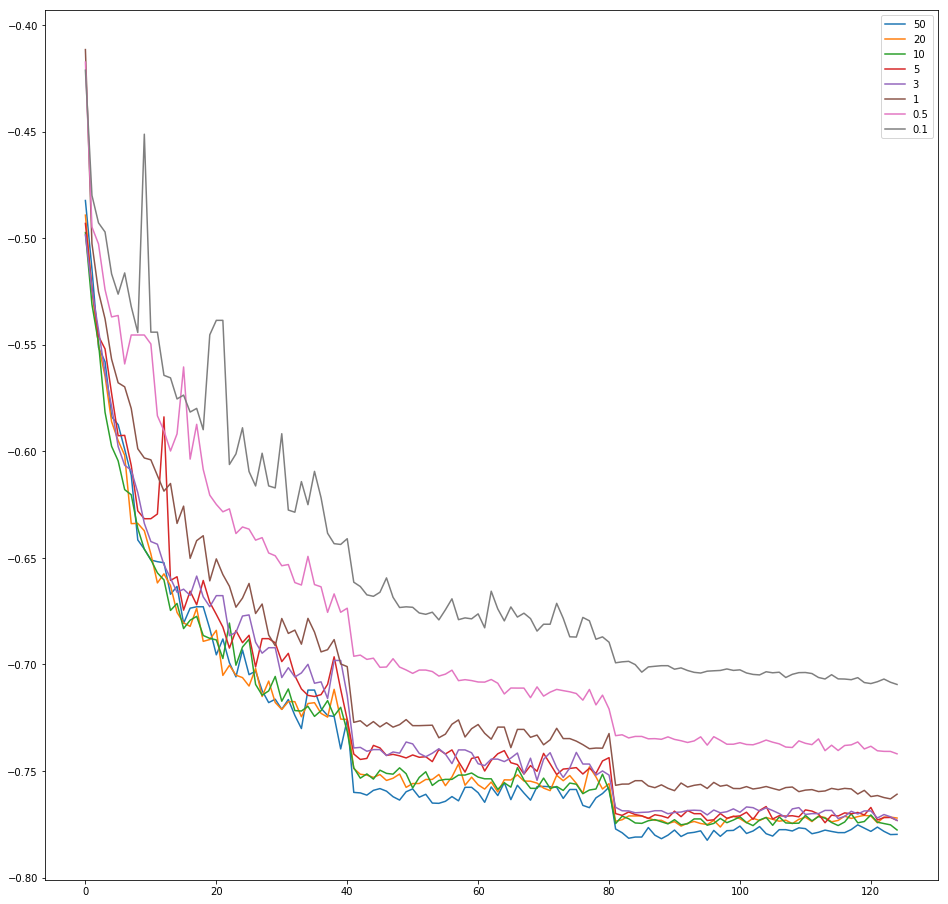

In [84]:
# Sometimes the validation similarity proximity spikes up for an epoch, so I just remove these values to smoothen the graph
val_soft_loss50 = remove_outlier(history50, 'val_soft_loss', -0.403)
val_soft_loss20 = remove_outlier(history20, 'val_soft_loss', -0.403)
val_soft_loss10 = remove_outlier(history10, 'val_soft_loss', -0.403)
val_soft_loss5 = remove_outlier(history5, 'val_soft_loss', -0.403)
val_soft_loss3 = remove_outlier(history3, 'val_soft_loss', -0.403)
val_soft_loss1 = remove_outlier(history1, 'val_soft_loss', -0.403)
val_soft_loss0_5 = remove_outlier(history0_5, 'val_soft_loss', -0.403)
val_soft_loss0_1 = remove_outlier(history0_1, 'val_soft_loss', -0.403)

fig=plt.figure(figsize=(16, 16))
plt.plot(val_soft_loss50[:125], label="50")
plt.plot(val_soft_loss20[:125], label="20")
plt.plot(val_soft_loss10[:125], label="10")
plt.plot(val_soft_loss5[:125], label="5")
plt.plot(val_soft_loss3[:125], label="3")
plt.plot(val_soft_loss1[:125], label="1")
plt.plot(val_soft_loss0_5[:125], label="0.5")
plt.plot(val_soft_loss0_1[:125], label="0.1")
plt.legend()
plt.show()

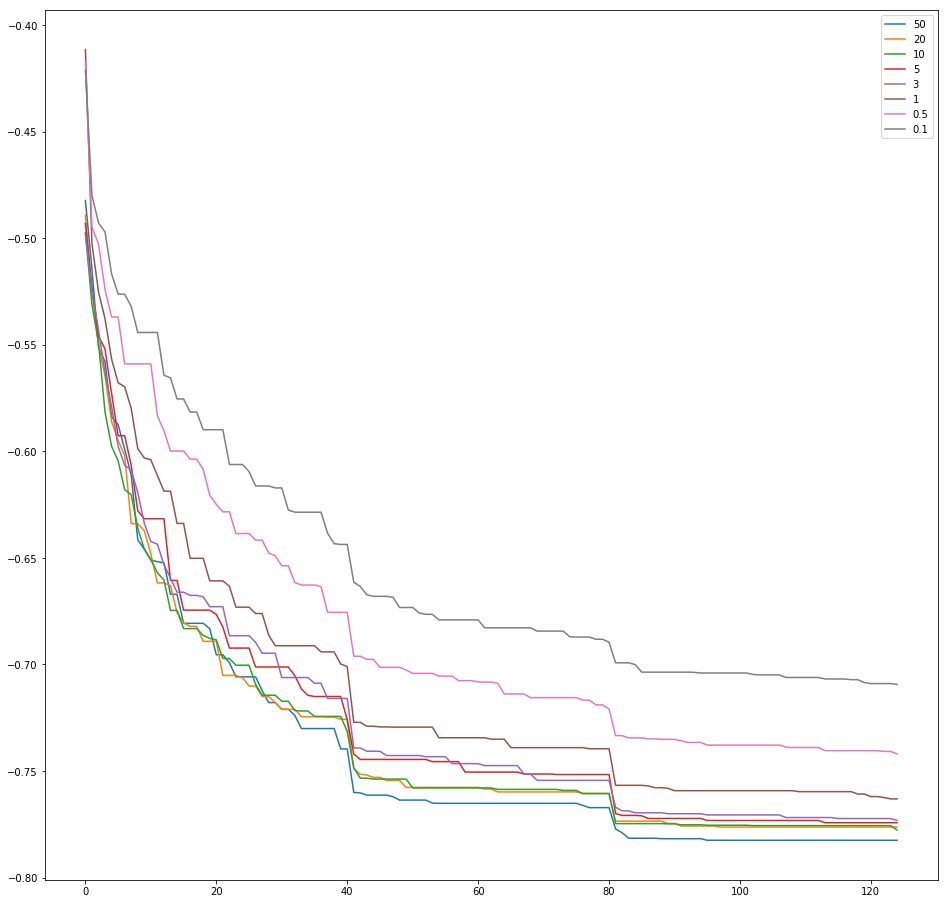

In [101]:
fig=plt.figure(figsize=(16, 16))
plt.plot(np.minimum.accumulate(val_soft_loss50[:125]), label="50")
plt.plot(np.minimum.accumulate(val_soft_loss20[:125]), label="20")
plt.plot(np.minimum.accumulate(val_soft_loss10[:125]), label="10")
plt.plot(np.minimum.accumulate(val_soft_loss5[:125]), label="5")
plt.plot(np.minimum.accumulate(val_soft_loss3[:125]), label="3")
plt.plot(np.minimum.accumulate(val_soft_loss1[:125]), label="1")
plt.plot(np.minimum.accumulate(val_soft_loss0_5[:125]), label="0.5")
plt.plot(np.minimum.accumulate(val_soft_loss0_1[:125]), label="0.1")
plt.legend()
plt.show()

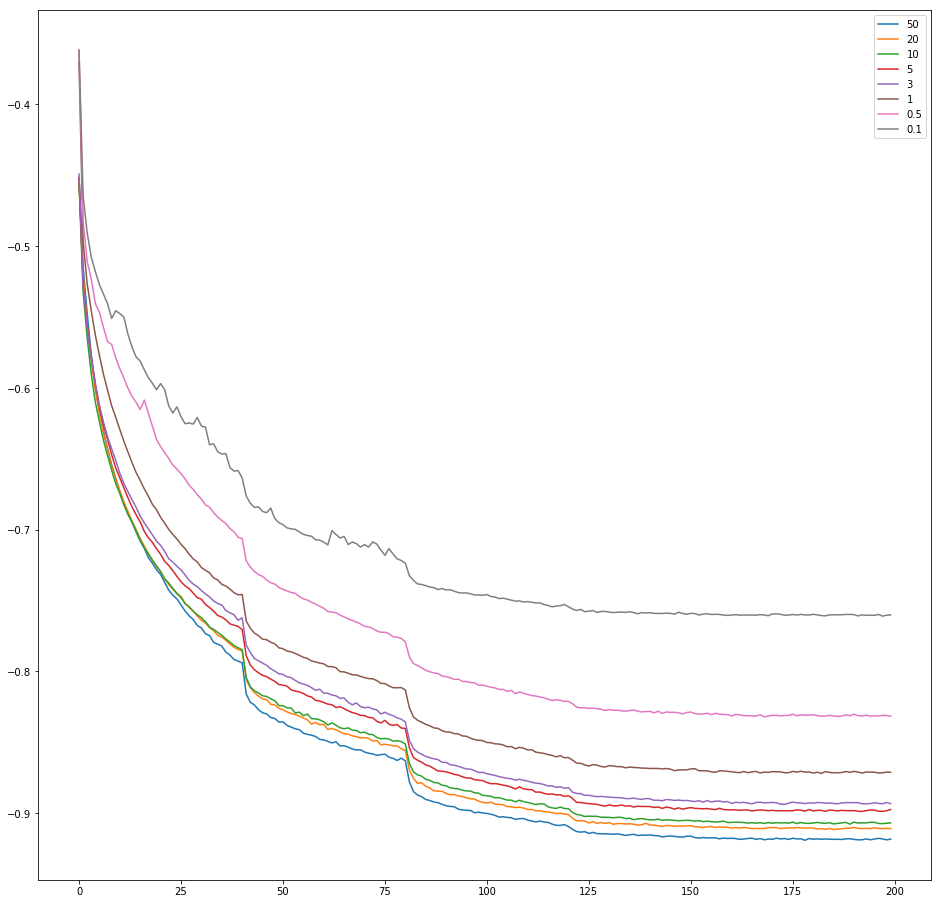

In [90]:
fig=plt.figure(figsize=(16, 16))
plt.plot(history50.history['soft_loss'], label="50")
plt.plot(history20.history['soft_loss'], label="20")
plt.plot(history10.history['soft_loss'], label="10")
plt.plot(history5.history['soft_loss'], label="5")
plt.plot(history3.history['soft_loss'], label="3")
plt.plot(history1.history['soft_loss'], label="1")
plt.plot(history0_5.history['soft_loss'], label="0.5")
plt.plot(history0_1.history['soft_loss'], label="0.1")
plt.legend()
plt.show()

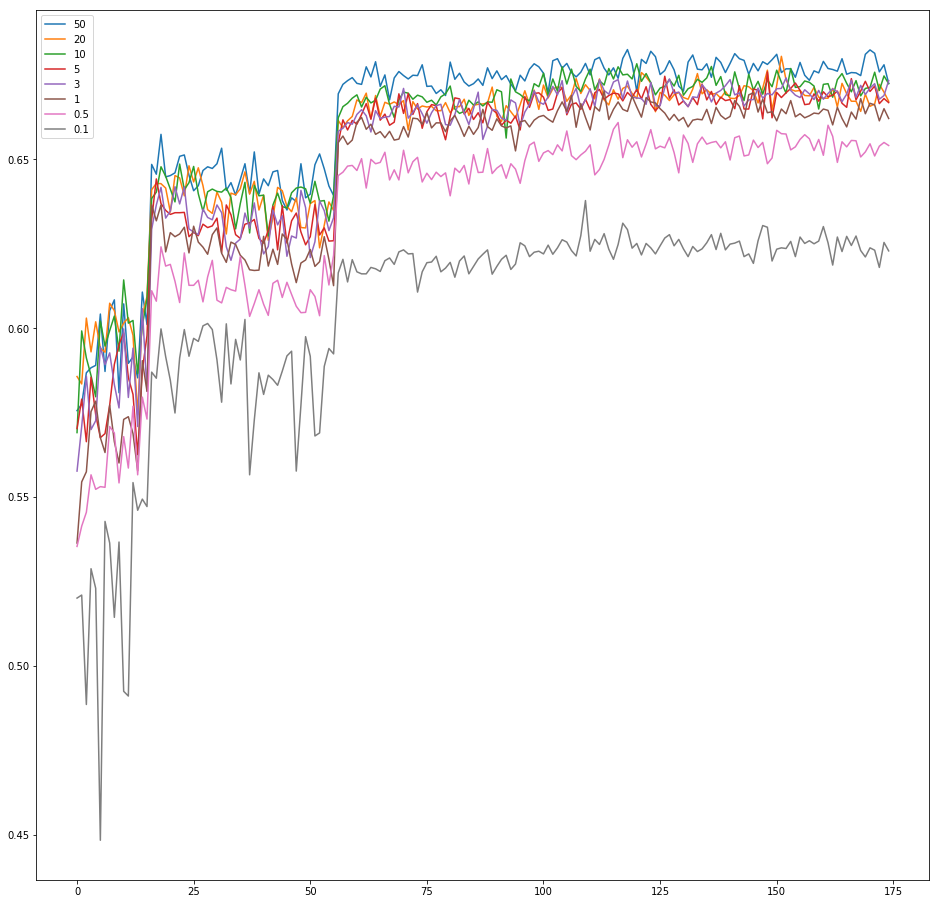

In [98]:
fig=plt.figure(figsize=(16, 16))
plt.plot(history50.history['val_hard_acc'][25:], label="50")
plt.plot(history20.history['val_hard_acc'][25:], label="20")
plt.plot(history10.history['val_hard_acc'][25:], label="10")
plt.plot(history5.history['val_hard_acc'][25:], label="5")
plt.plot(history3.history['val_hard_acc'][25:], label="3")
plt.plot(history1.history['val_hard_acc'][25:], label="1")
plt.plot(history0_5.history['val_hard_acc'][25:], label="0.5")
plt.plot(history0_1.history['val_hard_acc'][25:], label="0.1")
plt.legend()
plt.show()

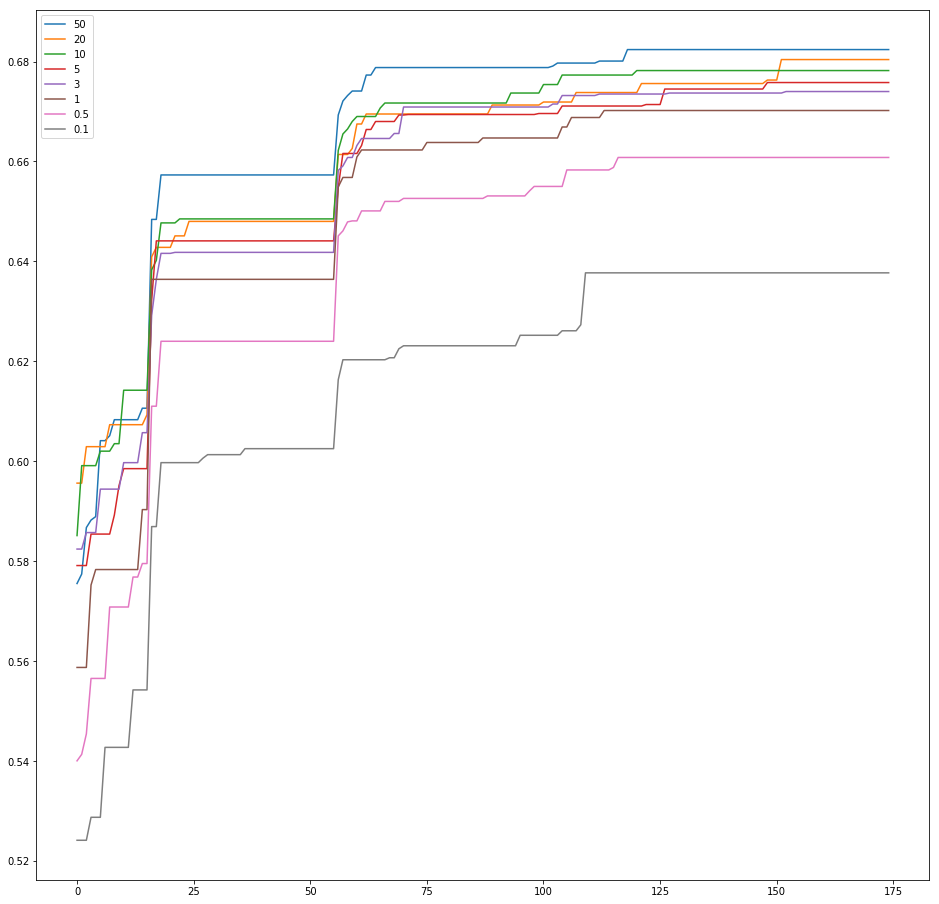

In [108]:
fig=plt.figure(figsize=(16, 16))
plt.plot(np.maximum.accumulate(history50.history['val_hard_acc'])[25:], label="50")
plt.plot(np.maximum.accumulate(history20.history['val_hard_acc'])[25:], label="20")
plt.plot(np.maximum.accumulate(history10.history['val_hard_acc'])[25:], label="10")
plt.plot(np.maximum.accumulate(history5.history['val_hard_acc'])[25:], label="5")
plt.plot(np.maximum.accumulate(history3.history['val_hard_acc'])[25:], label="3")
plt.plot(np.maximum.accumulate(history1.history['val_hard_acc'])[25:], label="1")
plt.plot(np.maximum.accumulate(history0_5.history['val_hard_acc'])[25:], label="0.5")
plt.plot(np.maximum.accumulate(history0_1.history['val_hard_acc'])[25:], label="0.1")
plt.legend()
plt.show()

In [39]:
#Top K Predictions
def pred_top_k(y_test_pred, label_embeddings_arr=label_embeddings_arr, k=5):
    sim_table = cosine_similarity(y_test_pred, label_embeddings_arr)
    top_k_guesses = np.argpartition(sim_table,range(99-k+1,100),axis=1)[:,99-k+1:]
    return sim_table, top_k_guesses

#Top k Accuracy
def calc_top_k_acc(top_k, y_test):
    correct = 0
    for i in range(y_test.shape[0]):
        if np.squeeze(y_test)[i] in top_k[i]:
            correct += 1
    return correct/float(y_test.shape[0])

def evaluate(model, x_test, y_test, label_embeddings_arr, k=5):
    y_test_pred_hard, y_test_pred_soft = model.predict(x_test)
    sim_table, top_k_guesses = pred_top_k(y_test_pred_soft, label_embeddings_arr, k=k)

    #Top prediction
    label_predictions = sim_table.argmax(axis=1)
    
    #Accuracy
    acc = np.sum((np.squeeze(y_test) == label_predictions)) / float(y_test.shape[0])
    top_k_acc = calc_top_k_acc(top_k_guesses, y_test)
    print("Accuracy: " + str(acc))
    print("Top " + str(k) + " Accuracy: " + str(top_k_acc))
    
    return acc, top_k_acc

In [ ]:
list_acc = []
list_top_k_acc = []

k = 5
temperatures = [50, 20, 10, 5, 3, 1, 0.5, 0.1]
for temperature in temperatures:
    print("Temperature: %s" % (temperature))
    
    save_dir = os.path.join(os.getcwd(), 'saved_models/%s/combined/temp%s/' % (model_type, temperature))
    files = [f for f in os.listdir(save_dir) if f[-3:]=='.h5']
    files.sort()
    model_filepath = os.path.join(save_dir, files[-1])
    print(files[-1])
    
    model = load_model(model_filepath)
    
    acc, top_k_acc = evaluate(model, x_test, y_test, label_embeddings_arr, k=k)
    list_acc.append(acc)
    list_top_k_acc.append(top_k_acc)
    print('\n')

In [ ]:
plt.subplot(1, 2, 1)
plt.show(temperatures, list_acc)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.show(temperatures, list_acc_top_k)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.title('Top %s Accuracy' % (k))

plt.show()

In [16]:
# save_dir = os.path.join(os.getcwd(), 'saved_models/%s/baseline/temp%s/' % (model_type, temperature))
# model_name = 'cifar100_%s_model.{epoch:03d}.h5' % model_type
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# filepath = os.path.join(save_dir, model_name)

In [17]:
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_soft_loss',
#                              verbose=1,
#                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [18]:
# model = resnet_v2(input_shape=input_shape, depth=depth, temperature=temperature)
# model.compile(optimizer=Adam(lr=lr_schedule(0)),
#               loss=losses, 
#               loss_weights = loss_weights, 
#               metrics=metrics)
# model.summary()

In [19]:
# history = model.fit_generator(epochs=epochs, 
#                               generator=multi_output_generator(datagen, x_train, 
#                                                                y_train, y_train_embeddings, batch_size=batch_size),
#                               steps_per_epoch=x_train.shape[0] // batch_size,
#                               validation_data=multi_output_generator(datagen, x_test, 
#                                                                      y_test, y_test_embeddings, batch_size=batch_size),
#                               validation_steps = x_test.shape[0] // batch_size,
#                               verbose=1, callbacks=callbacks)

In [20]:
# history_filepath = os.path.join(save_dir, 'cifar100_%s_w2v_history_temp.pk' % (model_type))
# pickle.dump(history, open(history_filepath, "wb"))

In [21]:
# best_model_filepath = os.path.join(save_dir, 'cifar100_%s_model.%03d.h5' % (model_type, 138))
# best_model = load_model(best_model_filepath)

# scores = best_model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

In [22]:
# def acc(top_k, y_true):
#     correct = 0
#     for i in range(y_true.shape[0]):
#         if y_true[i] in top_k[i]:
#             correct += 1
#     return correct/float(y_true.shape[0])

# y_pred = best_model.predict(x_test)
# print("Accuracy: %f" % (np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)) / float(len(y_test))))

# k = 5
# y_pred_top_k = y_pred.argsort()[:,-k:]
# print("Top %d accuracy: %f" % (k, acc(y_pred_top_k, np.argmax(y_test, axis=1))))